# Evaluation of Stan and best Neural Network model

This notebook will implement Stan inference and neural network inference on SIR data and evaluate both it's accuracy. 

The SIR model used will be a deterministic process stochastic observations model.

In [1]:
# Imports

from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from torch import nn
import os
from global_utils import generate_data, PosteriorMeanEstimator, evaluate_NN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


The below test set will be used to simultaneously evaluate Stan and the Neural Network

In [2]:
theta_test_final, _, case_test_final = generate_data(N=300, days=100, batch_size=1024, process="d", observations="s")

# Stan fitting

### Fitting Stan model to a SIR trajectory

In [3]:
def run_stan_inference(data):
    model = CmdStanModel(stan_file="sir-demo.stan")
    fit = model.sample(
        data=data,
        seed=42,
        chains=4,
        parallel_chains=4,
        iter_warmup=1000,
        iter_sampling=2000,
        show_progress=False
    )
    return fit


theta, processData, caseData = generate_data(N=300, days=100, batch_size=1, process="d", observations="s", beta=1.5, gamma=0.5)
observed_cases = caseData[0, 0, :].numpy().astype(int)
data = {'T': 100, 'N': 300, 'cases': observed_cases}
fit = run_stan_inference(data)

18:29:22 - cmdstanpy - INFO - CmdStan start processing
18:29:22 - cmdstanpy - INFO - Chain [1] start processing
18:29:22 - cmdstanpy - INFO - Chain [2] start processing
18:29:22 - cmdstanpy - INFO - Chain [3] start processing
18:29:22 - cmdstanpy - INFO - Chain [4] start processing
18:29:23 - cmdstanpy - INFO - Chain [2] done processing
18:29:23 - cmdstanpy - INFO - Chain [1] done processing
18:29:23 - cmdstanpy - INFO - Chain [3] done processing
18:29:23 - cmdstanpy - INFO - Chain [4] done processing


### Plotting the posterior distribution for gamma and beta

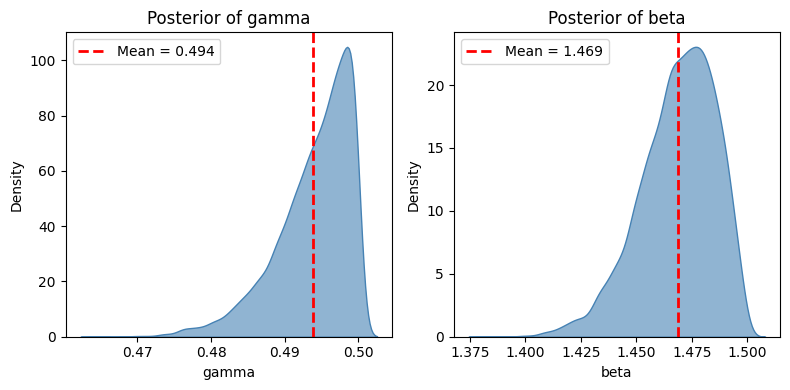

In [4]:
def plot_posterior_densities(fit, params):
    draws = fit.draws_pd()

    n_params = len(params)
    fig, axes = plt.subplots(1, n_params, figsize=(4 * n_params, 4))

    if n_params == 1:
        axes = [axes]

    for ax, param in zip(axes, params):
        values = draws[param]
        mean_val = values.mean()

        sns.kdeplot(values, fill=True, ax=ax, color="steelblue", alpha=0.6)
        ax.axvline(mean_val, color="red", linestyle="--", linewidth=2, label=f"Mean = {mean_val:.3f}")

        ax.set_title(f"Posterior of {param}")
        ax.set_xlabel(param)
        ax.set_ylabel("Density")
        ax.legend()

    plt.tight_layout()
    plt.show()


plot_posterior_densities(fit, params=("gamma", "beta"))

# Simultaneous evaluation of Stan and Neural Network

In [ ]:
def evaluate_stan_on_batch(batch_size, N=300, days=100, theta_batch=None, case_batch=None):
    if theta_batch is None or case_batch is None:
        theta_batch, _, case_batch = generate_data(
            N=N, days=days, batch_size=batch_size, process="d", observations="s"
        )

    # Move to numpy
    theta_batch = theta_batch.detach().cpu().numpy()
    case_batch = case_batch.detach().cpu().numpy()

    beta_preds, gamma_preds = [], []
    beta_trues, gamma_trues = [], []

    for i in range(batch_size):
        cases_i = case_batch[i, 0, :].astype(int).tolist()
        beta_true = float(theta_batch[i, 0])
        gamma_true = float(theta_batch[i, 1])

        data = {"T": days, "N": N, "cases": cases_i}
        fit = run_stan_inference(data)

        draws = fit.draws_pd()
        beta_preds.append(draws["beta"].mean())
        gamma_preds.append(draws["gamma"].mean())
        beta_trues.append(beta_true)
        gamma_trues.append(gamma_true)

    # Convert to numpy arrays
    beta_preds = np.array(beta_preds)
    gamma_preds = np.array(gamma_preds)
    beta_trues = np.array(beta_trues)
    gamma_trues = np.array(gamma_trues)

    # Compute test loss (MSE on both parameters)
    loss_fn = nn.MSELoss()
    y_true = torch.tensor(np.column_stack([beta_trues, gamma_trues]), dtype=torch.float32)
    y_pred = torch.tensor(np.column_stack([beta_preds, gamma_preds]), dtype=torch.float32)
    test_loss = loss_fn(y_pred, y_true).item()

    # Plot results
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Beta
    axes[0].scatter(beta_preds, beta_trues, alpha=0.6, color="blue")
    min_beta = min(min(beta_preds), min(beta_trues))
    max_beta = max(max(beta_preds), max(beta_trues))
    axes[0].plot([min_beta, max_beta], [min_beta, max_beta], 'r--', label='Perfect Prediction')
    axes[0].set_xlabel("Posterior mean $\\beta$ (Stan)")
    axes[0].set_ylabel("True $\\beta$")
    axes[0].set_title("Stan: Predicted vs True $\\beta$")
    axes[0].grid(True)
    axes[0].legend()

    # Gamma
    axes[1].scatter(gamma_preds, gamma_trues, alpha=0.6, color="blue")
    min_gamma = min(min(gamma_preds), min(gamma_trues))
    max_gamma = max(max(gamma_preds), max(gamma_trues))
    axes[1].plot([min_gamma, max_gamma], [min_gamma, max_gamma], 'r--', label='Perfect Prediction')
    axes[1].set_xlabel("Posterior mean $\\gamma$ (Stan)")
    axes[1].set_ylabel("True $\\gamma$")
    axes[1].set_title("Stan: Predicted vs True $\\gamma$")
    axes[1].grid(True)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    return {
        "beta_preds": beta_preds,
        "gamma_preds": gamma_preds,
        "beta_trues": beta_trues,
        "gamma_trues": gamma_trues,
        "test_loss": test_loss,
    }


results = evaluate_stan_on_batch(
    batch_size=1024,
    N=300,
    days=100
)

print(f"Test Loss (MSE on beta and gamma): {results['test_loss']}")

18:30:08 - cmdstanpy - INFO - CmdStan start processing
18:30:08 - cmdstanpy - INFO - Chain [1] start processing
18:30:08 - cmdstanpy - INFO - Chain [2] start processing
18:30:08 - cmdstanpy - INFO - Chain [3] start processing
18:30:08 - cmdstanpy - INFO - Chain [4] start processing
18:30:09 - cmdstanpy - INFO - Chain [4] done processing
18:30:09 - cmdstanpy - INFO - Chain [3] done processing
18:30:09 - cmdstanpy - INFO - Chain [1] done processing
18:30:09 - cmdstanpy - INFO - Chain [2] done processing
18:30:09 - cmdstanpy - INFO - CmdStan start processing
18:30:09 - cmdstanpy - INFO - Chain [1] start processing
18:30:09 - cmdstanpy - INFO - Chain [2] start processing
18:30:09 - cmdstanpy - INFO - Chain [3] start processing
18:30:09 - cmdstanpy - INFO - Chain [4] start processing
18:30:10 - cmdstanpy - INFO - Chain [4] done processing
18:30:10 - cmdstanpy - INFO - Chain [2] done processing
18:30:10 - cmdstanpy - INFO - Chain [3] done processing
18:30:10 - cmdstanpy - INFO - Chain [1] do

Loading model from best_model.pth


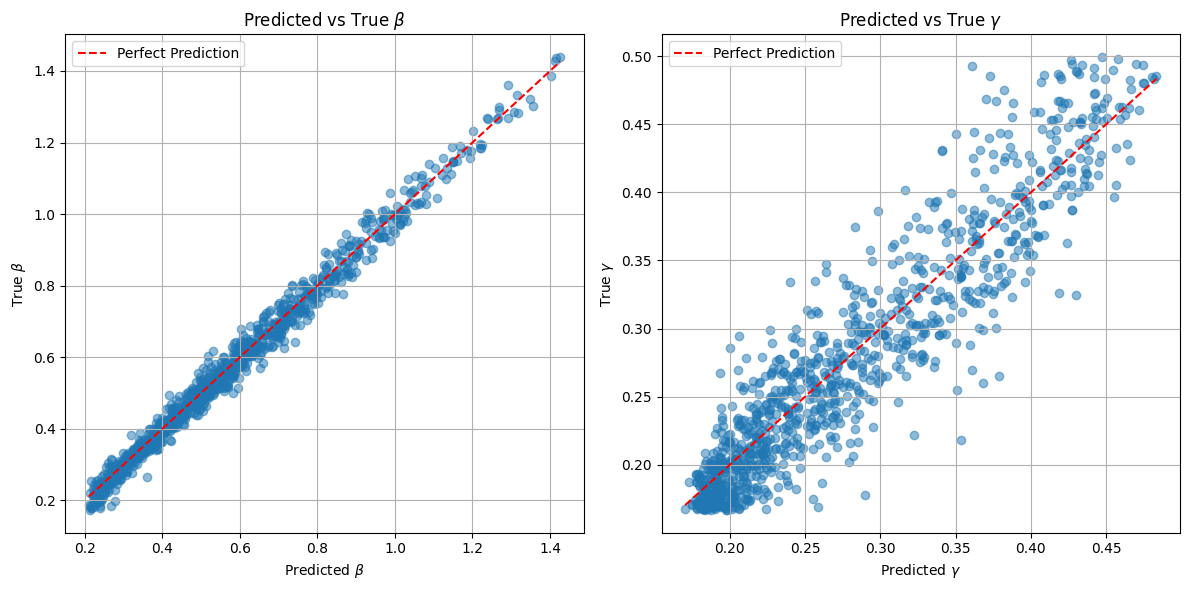

Test Loss: 0.0009099228191189468


In [6]:
# Best Hyperparameters obtained from Optuna
dropout = 0.002519145083582702
lr = 3.519559766293919e-05
estimator_width = 256
kernel_size = 7
batch_size = 32
summary_stats = 128
summary_channels = 32
n_batches_per_epoch = int(8192 / batch_size)

model_path = "best_model.pth"

if os.path.exists(model_path):
    print(f"Loading model from {model_path}")
    model = PosteriorMeanEstimator(
        summary_stats=summary_stats,
        summary_kernel_size=kernel_size,
        summary_channels=summary_channels,
        estimator_width=estimator_width,
        output_dim=2,
        dropout=dropout
    )
    model.load_state_dict(torch.load(model_path, map_location=device))

model.to(device)
test_loss = evaluate_NN(NN=model, device=device, x_test=case_test_final, y_test=theta_test_final)

print(f"Test Loss: {test_loss}")